In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nnTreeVB.data import evolve_seqs_full_homogeneity                                              
from nnTreeVB.data import build_tree_from_nwk
from nnTreeVB.data import SeqCollection
from nnTreeVB.data import build_msa_categorical

from nnTreeVB.reports import plot_grads_weights_epochs

from nnTreeVB.models import VB_nnTree

import time
import math
import random
import copy
from pprint import pprint
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

# import logomaker as lm
# import pandas as pd
# import seaborn as sns

%matplotlib inline

# torch.use_deterministic_algorithms(True)
torch.set_printoptions(precision=4, sci_mode=False)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', "r'All-NaN (slice|axis) encountered'")

## Alignment simulation

In [4]:
verbose = True

In [5]:
# Data preparation
alignment_len = 3000

str_tree = "(((1:0.3,2:0.7)N1:0.15,3:0.2)N2:0.1,4:0.4);"
# str_tree = "(((tx1:0.3,tx2:0.7)N1:0.15,tx3:0.2)N2:0.1,tx4:0.4);"
# str_tree = "(tx2:1.0411,tx4:0.8121,(tx1:1.1242,tx3:0.9130)N1:1.1095);"
# str_tree = "((1:0.3,2:0.7)N1:0.15,3:0.2,4:0.4);"
# str_tree = "((tx2:0.3,tx1:0.7)N1:0.15,tx3:0.2);"
# str_tree = "(1:0.1,2:0.2,3:0.3,4:0.4);"

#            "AG"  "AC"  "AT"  "GC"  "GT" "CT"
sim_rates = [0.16, 0.05, 0.16, 0.09, 0.3, 0.24]
evo_rates = [0.16, 0.05, 0.16, 0.09, 0.3, 0.24]

#             A     C    G     T
sim_freqs = [0.1, 0.45, 0.3, 0.15]
#             A     G    C     T
evo_freqs = [0.1, 0.3, 0.45, 0.15]


ete_tree, taxa, nodes = build_tree_from_nwk(str_tree)
logl_tree = copy.copy(ete_tree)

all_seqdict = evolve_seqs_full_homogeneity(
        str_tree,
        fasta_file=None,
        nb_sites=alignment_len,
        subst_rates=sim_rates,
        state_freqs=sim_freqs,
        return_anc=True,
        verbose=verbose)

sequences = [all_seqdict[s] for s in taxa]

Evolving new sequences with the amazing Pyvolve for None


In [6]:
device = torch.device("cpu")
# # device = torch.device("cuda")

In [7]:
gtr_freqs = torch.tensor(evo_freqs)
print("\nFrequencies")
print(gtr_freqs)
print(gtr_freqs.sum())

gtr_rates = torch.tensor(evo_rates) # AG, AC, AT, GC, GT, CT
print("\nRelative rates")
print(gtr_rates)
print(gtr_rates.sum())


Frequencies
tensor([0.1000, 0.3000, 0.4500, 0.1500])
tensor(1.)

Relative rates
tensor([0.1600, 0.0500, 0.1600, 0.0900, 0.3000, 0.2400])
tensor(1.)


In [8]:
true_branches = torch.zeros(len(ete_tree.get_descendants()))
# print(true_branches.shape[0])

for node in ete_tree.traverse("postorder"):

    if node.rank < true_branches.shape[0]:
#         print(node.name, node.rank, node.dist)
        true_branches[node.rank] = node.dist

true_branches = true_branches.unsqueeze(-1)
print("\ntrue_branches")
print(true_branches)
print(true_branches.sum())


true_branches
tensor([[0.3000],
        [0.7000],
        [0.2000],
        [0.4000],
        [0.1500],
        [0.1000]])
tensor(1.8500)


In [9]:
true_branches.shape

torch.Size([6, 1])

In [10]:
motifs_cats = build_msa_categorical(sequences)
X = torch.from_numpy(motifs_cats.data)
V = X.clone().detach()
V_counts = torch.ones(V.shape[0]).detach()
# X_counts = torch.ones(X.shape[0])
X, X_counts = X.unique(dim=0, return_counts=True)

print(X.shape)
print(X_counts)

torch.Size([221, 4, 4])
tensor([ 19,   9,   7,   2,  15,   4,   3,   3,   9,   2,   1,   1,   2,  19,
         16,  19,   1,  12,  54,  15,   1,   8,   9,  23,   5,   1,   2,   9,
         17,  13,  12,  23,   6,  12,  11,  43,   4,   2,   1,   1,   3,   2,
          4,   1,   1,   1,   5,   2,   3,   2,   1,   1,   1,   3,   6,   9,
          9,   3,   1,  11,  77,  12,   4,   2,   6,   6,   1,   1,   1,   1,
         20,  36,  19,   3,  68, 474,  74,  19,   9,  40,  30,   4,   5,   7,
          7,   6,   7,  16,  12,   2,  14, 124,  17,   5,   7,  10,  42,   5,
          6,   3,   3,   4,   1,   1,   2,  35,   1,   3,   1,   5,   9,   2,
          3,   4,   8,   9,   1,   3,  17,   7,  11,  15,  50,  11,   2,   2,
         13,  13,  10,   3,   9,  69,  15,   1,  22,  20,  89,   7,   2,   1,
          2,   4,  10,  15,  18,   5,   7,  35,  20,   7,  40,  57, 187,  26,
          3,   7,   4,   8,   4,   2,   4,   2,   1,   5,   2,   6,  34,   4,
          4,  15,   2,   1,   1,   1,   

## True log likelihood

In [11]:
from nnTreeVB.models.evo_models import pruning
from nnTreeVB.models.evo_models import build_GTR_transition_matrix

tm = build_GTR_transition_matrix(true_branches.unsqueeze(0), 
                                 gtr_rates.unsqueeze(0), 
                                 gtr_freqs.unsqueeze(0))

true_lls = (pruning(logl_tree, X.unsqueeze(0), tm, gtr_freqs.unsqueeze(0)) * X_counts).sum()
true_lls

tensor(-11939.3936)

## nnTreeVB model initialization

In [12]:
# Hyper parameters
seed = 34432
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_dim = 4
# Number of sequences
m_dim = len(ete_tree.get_leaf_names())
# Number of internal nodes
a_dim = len(ete_tree.get_descendants()) - m_dim + 1
# Number of branches
b_dim = len(ete_tree.get_edges()) - 1

h_dim = 32
nb_layers = 3

# alpha_kl = 0.0001
print(m_dim)

4


In [13]:
evoModel = VB_nnTree(
    x_dim,
    m_dim,
    b_dim,
    a_dim,
    subs_model="gtr",  # jc69 | k80 | hky | gtr
    predict_ancestors=False,
    
    # branch lengths follows gamma
    b_encoder_type="gamma_ind",
    b_init_distr=[0.1, 0.1],
    b_hp=torch.tensor([0.1, 1.]),

#     # branch lengths fixed
#     b_encoder_type="fixed",
#     b_init_distr=true_branches.detach(),

#     ## Compound branch lengths
#     b_encoder_type="dirichlet_nn_ind",
#     b_init_distr=[1.]*b_dim,
#     b_hp=[0.1]*b_dim,
#     # Tree lengths
#     t_encoder_type="gamma_nn_ind",
#     t_init_distr=[1., 1.],
#     t_hp=[1., 1.],

    # Tree length fixed
#     t_encoder_type="fixed",
#     t_init_distr=torch.tensor([1.85]),
    
    # kappa
#     k_encoder_type="gamma_nn_ind",
#     k_init_distr=[1., 0.1],
#     k_hp=[0.1, 0.1],
    
#     k_encoder_type="fixed",
#     k_init_distr=torch.tensor([1.5]),
    
#     # rates
#     r_encoder_type="dirichlet_ind",
#     r_init_distr=[0.1]*6,
#     r_hp=torch.ones(6).tolist(),
    
    r_encoder_type="fixed",
    r_init_distr=gtr_rates.detach(),
    
#     # frequencies
#     f_encoder_type="dirichlet_ind",
#     f_init_distr=[1.]*4,
#     f_hp=torch.ones(4).tolist(),

    f_encoder_type="fixed",
    f_init_distr=gtr_freqs.detach(),

    #
    h_dim=h_dim,
    nb_layers=nb_layers,
    device=device
)

In [14]:
# Fitting parameters
n_epochs = 1000
learning_rate = 0.0005
weight_decay = 0.000001

nb_samples = 100
sample_temp=0.1

## nnTreeVB model fitting

In [15]:
r = evoModel.fit(
    copy.copy(ete_tree),
    X, 
    X_counts,
    elbo_type="elbo_kl",
    latent_sample_size=nb_samples,
    max_iter=n_epochs,
    optim="sgd",
    optim_learning_rate=learning_rate,
    optim_weight_decay=weight_decay,
    save_fit_history=True,
    save_grad_stats=True,
    save_weight_stats=True,
    verbose=2
)

0m 41s	 Train Epoch: 1000 	 ELBO: -21685.350	 Lls -19345.799	 KLs 2339.551
Optimization rate 1.0


In [16]:
s = evoModel.sample(copy.copy(ete_tree),
    V, 
    V_counts,
    elbo_type="elbo_kl",
    latent_sample_size=nb_samples
)

In [17]:
print(s["b"].mean(0))
print(s["b"].mean(0).sum())

[[0.24179485]
 [0.31079793]
 [0.26175708]
 [0.15628146]
 [0.14883938]
 [0.16685249]]
1.2863232


In [18]:
# print(s["b1"].mean(0))
# print(s["b1"].mean(0).sum())

In [19]:
print(true_branches)
print(true_branches.sum())

tensor([[0.3000],
        [0.7000],
        [0.2000],
        [0.4000],
        [0.1500],
        [0.1000]])
tensor(1.8500)


In [ ]:
# s["r"].mean(0)

In [ ]:
# gtr_rates

In [ ]:
# s["f"].mean(0)

In [ ]:
# gtr_freqs

<Figure size 640x480 with 0 Axes>

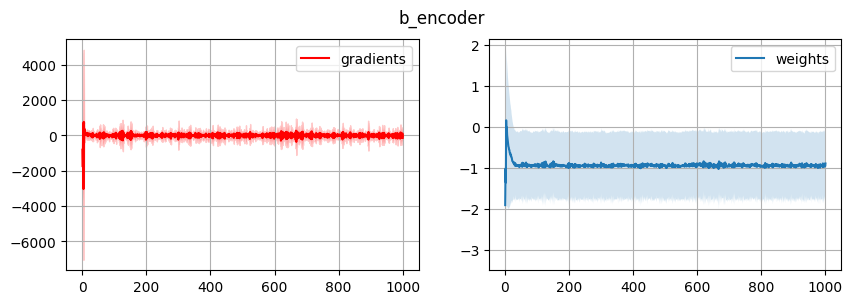

In [20]:
plot_grads_weights_epochs(r, 'b_encoder', False, sizefont=10, fig_size=(10,3))

In [ ]:
# plot_grads_weights_epochs(r, 't_encoder', False, sizefont=10, fig_size=(10,3))

In [ ]:
# plot_grads_weights_epochs(r, 'r_encoder', False, sizefont=10, fig_size=(10,3))

In [ ]:
# plot_grads_weights_epochs(r, 'f_encoder', False, sizefont=10, fig_size=(10,3))